In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from terrain_env import TerrainEnv

In [ ]:
# Discretize action space
def create_action_space(n_actions=16):
    return np.linspace(0.0, 2.0 * math.pi, num=n_actions, endpoint=False)

# Discretize continuous (x,y) to integer grid indices
def discretize_state(state, n_bins=20, max_coord=20.0):
    x, y = state
    ix = int(np.clip(x / max_coord * n_bins, 0, n_bins - 1))
    iy = int(np.clip(y / max_coord * n_bins, 0, n_bins - 1))
    return ix, iy

# Epsilon decay for e-greedy
def epsilon_decay(ep, eps_start=0.5, eps_end=0.05, decay_episodes=400):
    if ep >= decay_episodes:
        return eps_end
    return eps_start - (eps_start - eps_end) * (ep / decay_episodes)

# Moving average smoothing of learning curves
def smooth(x, window=20):
    x = np.asarray(x)
    if len(x) < window:
        return x
    cumsum = np.cumsum(np.insert(x, 0, 0))
    sm = (cumsum[window:] - cumsum[:-window]) / float(window)
    pad = np.full(window - 1, sm[0])
    return np.concatenate([pad, sm])

In [ ]:
# Q-Learning Agent: Tabular Method
class QLearningAgent:
    def __init__(self, n_bins=20, actions=None, alpha=0.2, gamma=0.99):
        self.n_bins = n_bins
        self.actions = actions
        self.n_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.q = np.zeros((n_bins, n_bins, self.n_actions), dtype=np.float32)

    def _state_idx(self, s):
        return discretize_state(s, self.n_bins)

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        ix, iy = self._state_idx(state)
        return int(np.argmax(self.q[ix, iy, :]))

    def train(self, env, num_episodes=600, max_steps=300):
        returns = []
        for ep in range(num_episodes):
            s = env.reset()
            ep_ret = 0.0
            eps = epsilon_decay(ep)
            for t in range(max_steps):
                a_idx = self.select_action(s, eps)
                theta = self.actions[a_idx]
                s_next, r, done = env.step(s, theta)
                ix, iy = self._state_idx(s)
                ix2, iy2 = self._state_idx(s_next)

                if done:
                    best_next = 0.0
                else:
                    best_next = np.max(self.q[ix2, iy2, :])

                td_target = r + self.gamma * best_next
                td_error = td_target - self.q[ix, iy, a_idx]
                self.q[ix, iy, a_idx] += self.alpha * td_error

                ep_ret += r
                s = s_next
                if done:
                    break
            returns.append(ep_ret)
        return np.array(returns)

    def greedy_rollout(self, env, start, max_steps=300):
        s = env.reset(start=start)
        traj = [s.copy()]
        total_r = 0.0
        for t in range(max_steps):
            a_idx = self.select_action(s, epsilon=0.0)
            theta = self.actions[a_idx]
            s_next, r, done = env.step(s, theta)
            traj.append(s_next.copy())
            total_r += r
            s = s_next
            if done:
                break
        return np.array(traj), total_r

In [ ]:
# SARSA Agent: Tabular Method
class SARSAAgent:
    def __init__(self, n_bins=20, actions=None, alpha=0.2, gamma=0.99):
        self.n_bins = n_bins
        self.actions = actions
        self.n_actions = len(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.q = np.zeros((n_bins, n_bins, self.n_actions), dtype=np.float32)

    def _state_idx(self, s):
        return discretize_state(s, self.n_bins)

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        ix, iy = self._state_idx(state)
        return int(np.argmax(self.q[ix, iy, :]))

    def train(self, env, num_episodes=600, max_steps=300):
        returns = []
        for ep in range(num_episodes):
            s = env.reset()
            eps = epsilon_decay(ep)
            a_idx = self.select_action(s, eps)
            ep_ret = 0.0
            for t in range(max_steps):
                theta = self.actions[a_idx]
                s_next, r, done = env.step(s, theta)
                ix, iy = self._state_idx(s)
                ep_ret += r

                if done:
                    td_target = r
                    td_error = td_target - self.q[ix, iy, a_idx]
                    self.q[ix, iy, a_idx] += self.alpha * td_error
                    break
                else:
                    a_next = self.select_action(s_next, eps)
                    ix2, iy2 = self._state_idx(s_next)
                    td_target = r + self.gamma * self.q[ix2, iy2, a_next]
                    td_error = td_target - self.q[ix, iy, a_idx]
                    self.q[ix, iy, a_idx] += self.alpha * td_error

                s = s_next
                a_idx = a_next
            returns.append(ep_ret)
        return np.array(returns)

    def greedy_rollout(self, env, start, max_steps=300):
        s = env.reset(start=start)
        traj = [s.copy()]
        total_r = 0.0
        for t in range(max_steps):
            a_idx = self.select_action(s, epsilon=0.0)
            theta = self.actions[a_idx]
            s_next, r, done = env.step(s, theta)
            traj.append(s_next.copy())
            total_r += r
            s = s_next
            if done:
                break
        return np.array(traj), total_r

In [ ]:
# DQN Agent: Deep RL Method
class DQNNet(nn.Module):
    def __init__(self, input_dim=2, n_actions=16):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.model(x)

class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0

    def push(self, s, a, r, s_next, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.pos] = (s, a, r, s_next, done)
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, d = zip(*batch)
        return (
            np.array(s, dtype=np.float32),
            np.array(a, dtype=np.int64),
            np.array(r, dtype=np.float32),
            np.array(s_next, dtype=np.float32),
            np.array(d, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, actions=None, gamma=0.99, lr=1e-3,
                  batch_size=64, buffer_capacity=20000):
        self.actions = actions
        self.n_actions = len(actions)
        self.gamma = gamma
        self.batch_size = batch_size

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_net = DQNNet(input_dim=2, n_actions=self.n_actions).to(self.device)
        self.target_net = DQNNet(input_dim=2, n_actions=self.n_actions).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.buffer = ReplayBuffer(capacity=buffer_capacity)
        self.update_target_every = 200
        self.global_step = 0

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        with torch.no_grad():
            s_tensor = torch.tensor(state, dtype=torch.float32,
                                    device=self.device).unsqueeze(0)
            q_values = self.q_net(s_tensor)
            a_idx = int(torch.argmax(q_values, dim=1).item())
        return a_idx

    def _optimize(self):
        if len(self.buffer) < self.batch_size:
            return
        s, a, r, s_next, d = self.buffer.sample(self.batch_size)

        s_t = torch.tensor(s, dtype=torch.float32, device=self.device)
        a_t = torch.tensor(a, dtype=torch.int64, device=self.device).unsqueeze(1)
        r_t = torch.tensor(r, dtype=torch.float32, device=self.device).unsqueeze(1)
        s_next_t = torch.tensor(s_next, dtype=torch.float32, device=self.device)
        d_t = torch.tensor(d, dtype=torch.float32, device=self.device).unsqueeze(1)

        q_values = self.q_net(s_t).gather(1, a_t)

        with torch.no_grad():
            next_q = self.target_net(s_next_t).max(1, keepdim=True)[0]
            target = r_t + self.gamma * (1.0 - d_t) * next_q

        loss = nn.MSELoss()(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.global_step += 1
        if self.global_step % self.update_target_every == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

    def train(self, env, num_episodes=600, max_steps=300):
        returns = []
        for ep in range(num_episodes):
            s = env.reset()
            eps = epsilon_decay(ep)
            ep_ret = 0.0
            for t in range(max_steps):
                a_idx = self.select_action(s, eps)
                theta = self.actions[a_idx]
                s_next, r, done = env.step(s, theta)

                self.buffer.push(s, a_idx, r, s_next, float(done))
                self._optimize()

                ep_ret += r
                s = s_next
                if done:
                    break
            returns.append(ep_ret)
        return np.array(returns)

    def greedy_rollout(self, env, start, max_steps=300):
        s = env.reset(start=start)
        traj = [s.copy()]
        total_r = 0.0
        for t in range(max_steps):
            a_idx = self.select_action(s, epsilon=0.0)
            theta = self.actions[a_idx]
            s_next, r, done = env.step(s, theta)
            traj.append(s_next.copy())
            total_r += r
            s = s_next
            if done:
                break
        return np.array(traj), total_r

In [ ]:
# Helpers
def plot_learning_curves(curves, labels):
    plt.figure(figsize=(8, 5))
    for c, lab in zip(curves, labels):
        plt.plot(smooth(c), label=lab)
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Learning curves on TerrainEnv")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_terrain_with_paths(env, paths, labels):
    grid_size = 80
    xs = np.linspace(0, 20, grid_size)
    ys = np.linspace(0, 20, grid_size)
    H = np.zeros((grid_size, grid_size))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            H[j, i] = env.height(x, y)

    plt.figure(figsize=(7, 6))
    plt.imshow(H, origin='lower', extent=[0, 20, 0, 20], aspect='equal')
    plt.colorbar(label="Height")

    goal = env.goal
    goal_radius = env.goal_radius
    circle = plt.Circle((goal[0], goal[1]), goal_radius,
                        edgecolor='red', facecolor='none', linewidth=2)
    plt.gca().add_patch(circle)
    plt.scatter([goal[0]], [goal[1]], c='red', marker='x', s=80, label="Goal")

    for traj, lab in zip(paths, labels):
        plt.plot(traj[:, 0], traj[:, 1], marker='.', linewidth=2, label=lab)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Best agent rollout trajectories")
    plt.legend()
    plt.tight_layout()
    plt.show()

def tail_mean(x, n=100):
    x = np.asarray(x)
    if len(x) >= n:
        return float(np.mean(x[-n:]))
    return float(np.mean(x))

In [ ]:
def main():
    # Train all agents and plot learning curves
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)

    env = TerrainEnv()
    n_actions = 16
    actions = create_action_space(n_actions)

    num_episodes = 600
    max_steps = 300

    q_agent = QLearningAgent(n_bins=20, actions=actions, alpha=0.3, gamma=0.99)
    sarsa_agent = SARSAAgent(n_bins=20, actions=actions, alpha=0.3, gamma=0.99)
    dqn_agent = DQNAgent(actions=actions, gamma=0.99, lr=1e-3)

    print("Training Q-Learning...")
    q_returns = q_agent.train(env, num_episodes=num_episodes, max_steps=max_steps)

    print("Training SARSA...")
    sarsa_returns = sarsa_agent.train(env, num_episodes=num_episodes, max_steps=max_steps)

    if dqn_agent is not None:
        print("Training DQN...")
        dqn_returns = dqn_agent.train(env, num_episodes=num_episodes, max_steps=max_steps)
    else:
        dqn_returns = None

    print("All agents trained!")
    curves = [q_returns, sarsa_returns]
    labels = ["Q-Learning", "SARSA"]
    if dqn_returns is not None:
        curves.append(dqn_returns)
        labels.append("DQN")

    plot_learning_curves(curves, labels)

    # Choose best agent and run rollouts
    scores = [
        tail_mean(q_returns),
        tail_mean(sarsa_returns),
    ]
    agents = [q_agent, sarsa_agent]
    agent_labels = ["Q-Learning", "SARSA"]

    if dqn_returns is not None:
        scores.append(tail_mean(dqn_returns))
        agents.append(dqn_agent)
        agent_labels.append("DQN")

    best_idx = int(np.argmax(scores))
    best_agent = agents[best_idx]
    best_label = agent_labels[best_idx]

    print("Best agent:", best_label)
    print("Tail-avg return (last 100 episodes):", scores[best_idx])

    # Start positions: (0,0) and 3 random points away from goal
    starts = [(0.0, 0.0)]
    for _ in range(3):
        while True:
            s = np.random.uniform(0.0, 20.0, size=2)
            if np.linalg.norm(s - env.goal) > 2.0:
                starts.append((float(s[0]), float(s[1])))
                break

    paths = []
    path_labels = []
    for i, st in enumerate(starts):
        traj, total_r = best_agent.greedy_rollout(env, start=st, max_steps=max_steps)
        paths.append(traj)
        path_labels.append(f"Start {i}: {st}, R={total_r:.1f}")

    plot_terrain_with_paths(env, paths, path_labels)

    print("\nAll agents & rewards (tail-avg last 100 episodes)")
    for lab, sc in zip(agent_labels, scores):
        print(f"{lab}: {sc:.2f}")

Training Q-Learning...
Training SARSA...
Training DQN...
All agents trained!


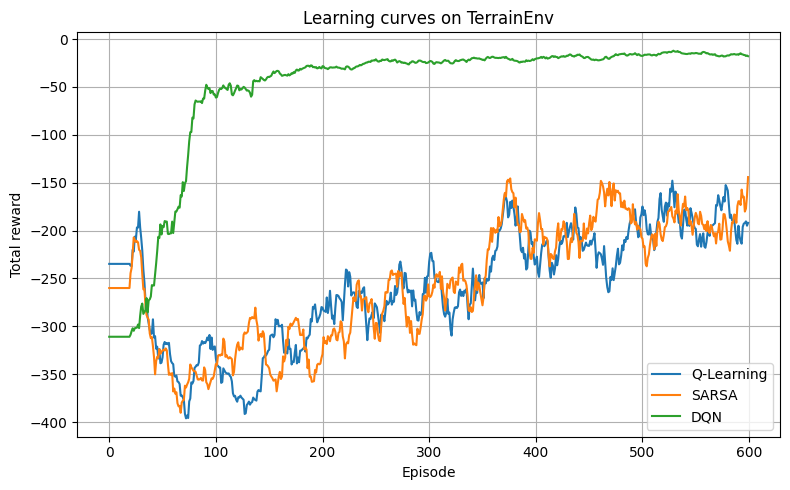

Best agent: DQN
Tail-avg return (last 100 episodes): -15.707848500594993


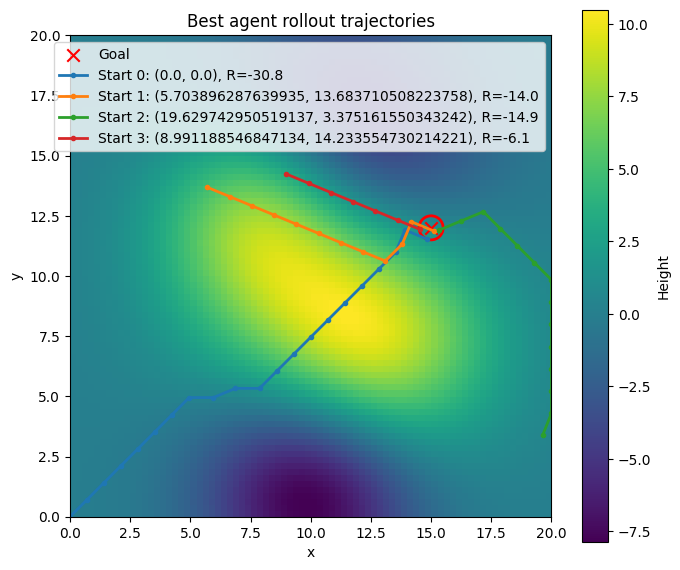


All agents & rewards (tail-avg last 100 episodes)
Q-Learning: -185.62
SARSA: -184.62
DQN: -15.71


In [ ]:
if __name__ == "__main__":
    main()